In [553]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict

sns.set_theme(style="whitegrid", context="paper")
sns.set_palette("coolwarm")
rs = check_random_state(42)

In [585]:
data_fama_french = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)
data_fama_french_momentum = pd.read_csv("data/F-F_Momentum_Factor.CSV", skiprows=13)
data_fama_french_industry_portfolios = pd.read_csv(
    "data/10_Industry_Portfolios.CSV", skiprows=11
)  # value weighted

fred_recessions = pd.read_csv("data/fred_recession_cycles.csv")

# data_fama_french_daily = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
# data_stocks = pd.read_csv("data/characteristics_data_feb2017.csv")

In [586]:
data_fama_french["Date"] = pd.to_datetime(data_fama_french["Date"], format="%Y%m")
data_fama_french = data_fama_french.set_index("Date")

data_fama_french_momentum["Date"] = pd.to_datetime(
    data_fama_french_momentum["Date"], format="%Y%m"
)
data_fama_french_momentum = data_fama_french_momentum.set_index("Date")

data_fama_french_industry_portfolios["Date"] = pd.to_datetime(
    data_fama_french_industry_portfolios["Date"], format="%Y%m"
)
data_fama_french_industry_portfolios = data_fama_french_industry_portfolios.set_index(
    "Date"
)

fred_recessions["Peak"] = pd.to_datetime(fred_recessions["Peak"], format="%Y-%m-%d")
fred_recessions["Trough"] = pd.to_datetime(fred_recessions["Trough"], format="%Y-%m-%d")


# data_fama_french_daily["Date"] = pd.to_datetime(data_fama_french_daily["Date"], format="%Y%m%d")
# data_fama_french_daily = data_fama_french_daily.set_index("Date")


# data_fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
# leaving the data in percentage format to reduce float precision errors

In [556]:
def plot_cumulative_returns(data, title="Cumulative Returns"):
    data = data.cumsum()
    if len(data) == 1:
        sns.lineplot(data=data, linewidth=2, dashes=False)
    else:
        sns.lineplot(data=data, palette="gist_earth", linewidth=1.5, dashes=False)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend(loc="upper left")
    plt.show()

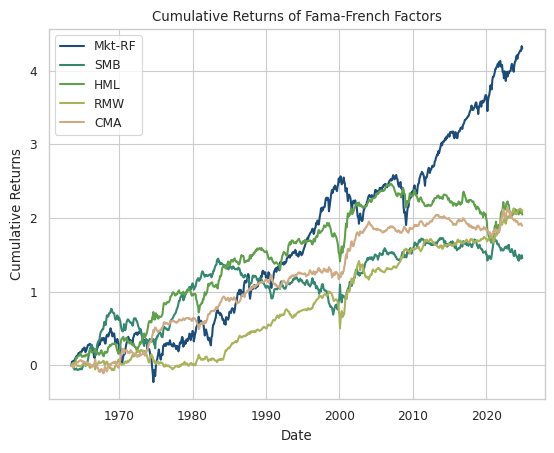

In [557]:
plot_cumulative_returns(
    data_fama_french[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]] / 100,
    title="Cumulative Returns of Fama-French Factors",
)

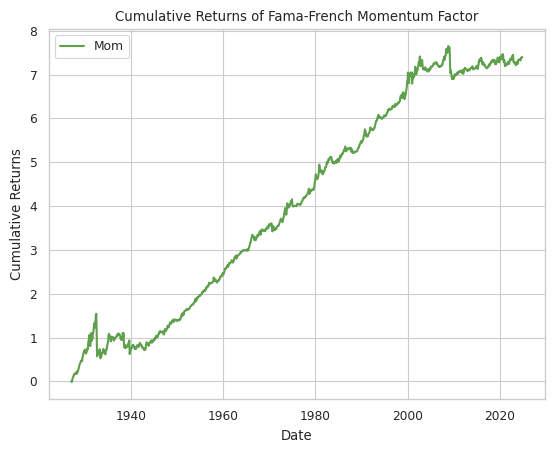

In [558]:
plot_cumulative_returns(
    data_fama_french_momentum[["Mom"]] / 100,
    title="Cumulative Returns of Fama-French Momentum Factor",
)

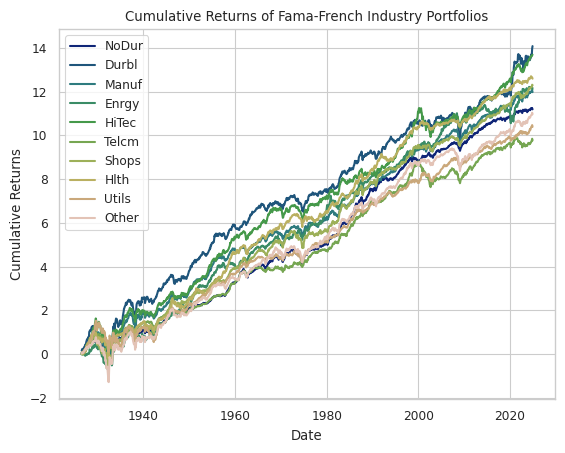

In [559]:
plot_cumulative_returns(
    data_fama_french_industry_portfolios[
        [
            "NoDur",
            "Durbl",
            "Manuf",
            "Enrgy",
            "HiTec",
            "Telcm",
            "Shops",
            "Hlth",
            "Utils",
            "Other",
        ]
    ]
    / 100,
    title="Cumulative Returns of Fama-French Industry Portfolios",
)

In [560]:
# data_stocks.drop(
#     columns=[
#         "idx",
#         "q10",
#         "q20",
#         "q50",
#         "prc",
#         "a2me",
#         "ato",
#         "beme",
#         "c",
#         "cto",
#         "d2a",
#         "dpi2a",
#         "e2p",
#         "fc2y",
#         "free_cf",
#         "investment",
#         "lturnover",
#         "noa",
#         "oa",
#         "ol",
#         "pcm",
#         "pm",
#         "prof",
#         "q",
#         "rna",
#         "roa",
#         "roe",
#         "s2p",
#         "sga2m",
#         "at",
#         "cum_return_12_2",
#         "cum_return_12_7",
#         "cum_return_1_0",
#         "cum_return_36_13",
#         "idio_vol",
#         "spread_mean",
#         "suv",
#         "rel_to_high_price",
#         "lev",
#     ],
#     inplace=True,
# )

# data_stocks.sort_values(by=["date"], ascending=[True], inplace=True)
# data_stocks["date"] = pd.to_datetime(data_stocks["date"])
# data_stocks.head()

Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [561]:
model_parameters_df = pd.concat(
    [data_fama_french, data_fama_french_momentum, data_fama_french_industry_portfolios],
    axis=1,
).dropna()
model_parameters_df

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90,-0.48,-0.07,-1.39,2.30,-0.68,-0.25,-1.05,0.57,0.81,-1.59
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01,4.87,6.54,6.19,3.94,5.13,4.28,6.42,9.56,4.20,5.44
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19,-1.69,-0.25,-0.78,-3.65,0.14,2.36,0.93,-4.07,-2.50,-3.18
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12,2.66,10.71,2.54,-0.33,8.30,3.43,0.51,3.38,-0.67,1.39
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74,-1.12,-5.17,0.30,-1.15,-0.29,4.14,-1.25,-1.65,-1.02,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79,4.11,-5.16,1.79,-2.92,1.35,1.21,1.35,6.44,4.55,3.03
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60,0.99,14.24,2.83,-3.17,2.96,5.63,3.67,-1.81,5.35,0.66
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87,-2.59,-3.14,-3.60,-0.54,-0.21,2.36,-1.14,-3.11,0.71,1.11


In [562]:
# X = data_fama_french.values.reshape(-1, 1)
# lengths = [len(data_fama_french)] * 6

X = model_parameters_df.values
lengths = [len(model_parameters_df)]

# X_daily = data_fama_french_daily.values
# lengths_daily = [len(data_fama_french_daily)]

In [563]:
# TODO add K-means initialization


def evaluate_hmm(X, lengths, rs):
    aic = []
    bic = []
    lls = []
    convergence_status = []
    iterations = []
    ns = [2, 3, 4, 5]
    models = defaultdict(list)
    # save in this format: {number_of_states: [(model, LL), ...]}
    best_models = defaultdict()

    for n in ns:
        best_ll = None
        best_model = None
        for _ in range(200):
            h = GaussianHMM(
                n,
                n_iter=2000,
                tol=1e-6,
                random_state=rs,
                covariance_type="full",
                verbose=False,
            )
            h.fit(X, lengths)
            score = h.score(X, lengths)
            models[n].append((h, score))
            if not best_ll or best_ll < score:
                best_ll = score
                best_model = h

        best_models[n] = best_model
        aic.append(best_model.aic(X))
        bic.append(best_model.bic(X))
        lls.append(best_model.score(X))
        convergence_status.append(best_model.monitor_.converged)
        iterations.append(best_model.monitor_.iter)

    print("Convergence Status: ", convergence_status)
    print("Iterations: ", iterations)
    return aic, bic, lls, convergence_status, iterations, best_models, models

In [564]:
def plot_selection(ns, aic, bic, lls):
    fig, ax = plt.subplots()
    ax.plot(ns, aic, label="AIC", color="blue", marker="o")
    ax.plot(ns, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ax2.plot(ns, lls, label="LL", color="orange", marker="o")
    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Using AIC/BIC for Model Selection")
    ax.set_ylabel("Criterion Value (lower is better)")
    ax2.set_ylabel("LL (higher is better)")
    ax.set_xlabel("Number of HMM Components")
    fig.tight_layout()
    plt.show()


# TODO add heuristic to choose optimal number of components, currently visually finding the elbow

In [565]:
def plot_ll_histograms(models):
    ns = sorted(models.keys())
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, n_components in enumerate(ns):
        component_scores = [score for (_, score) in models[n_components]]

        axes[idx].hist(
            component_scores, bins=25, edgecolor="k", alpha=0.65, density=True
        )

        axes[idx].set_title(
            f"{n_components}-State HMM\n(n={len(component_scores)})", pad=12
        )
        axes[idx].set_xlabel("Log-Likelihood", labelpad=8)
        axes[idx].set_ylabel("Density", labelpad=8)
        axes[idx].grid(True, linestyle="--", alpha=0.6)

        mean_ll = np.mean(component_scores)
        axes[idx].axvline(
            mean_ll,
            color="r",
            linestyle="--",
            linewidth=1.5,
            label=f"Mean: {mean_ll:.1f}",
        )
        axes[idx].legend()

    plt.tight_layout(pad=2.0)
    plt.show()

Model is not converging.  Current: -27615.791880815705 is not greater than -27615.791644455054. Delta is -0.00023636065088794567
Model is not converging.  Current: -27608.898440193618 is not greater than -27512.896533928106. Delta is -96.00190626551193
Model is not converging.  Current: -26937.790555990992 is not greater than -26937.790555972333. Delta is -1.8659193301573396e-08
Model is not converging.  Current: -26931.668452553287 is not greater than -26931.668451028327. Delta is -1.52496068039909e-06
Model is not converging.  Current: -26618.15154390893 is not greater than -26618.151543824326. Delta is -8.460483513772488e-08
Model is not converging.  Current: -25874.006169430624 is not greater than -25874.006168816137. Delta is -6.144873623270541e-07
Model is not converging.  Current: -25874.006169447577 is not greater than -25874.006168804168. Delta is -6.434092938434333e-07
Model is not converging.  Current: -25824.255974203017 is not greater than -25824.25596168805. Delta is -1.2

Convergence Status:  [True, True, True, True]
Iterations:  [56, 23, 118, 80]


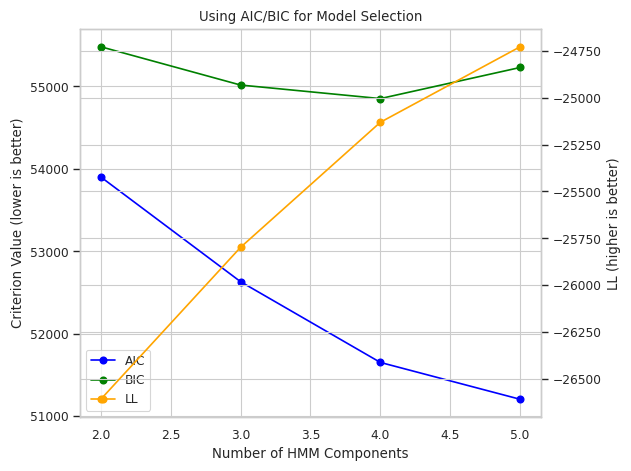

In [566]:
aic, bic, lls, convergence_status, iterations, best_models, models = evaluate_hmm(
    X, lengths, rs
)
plot_selection([2, 3, 4, 5], aic, bic, lls)

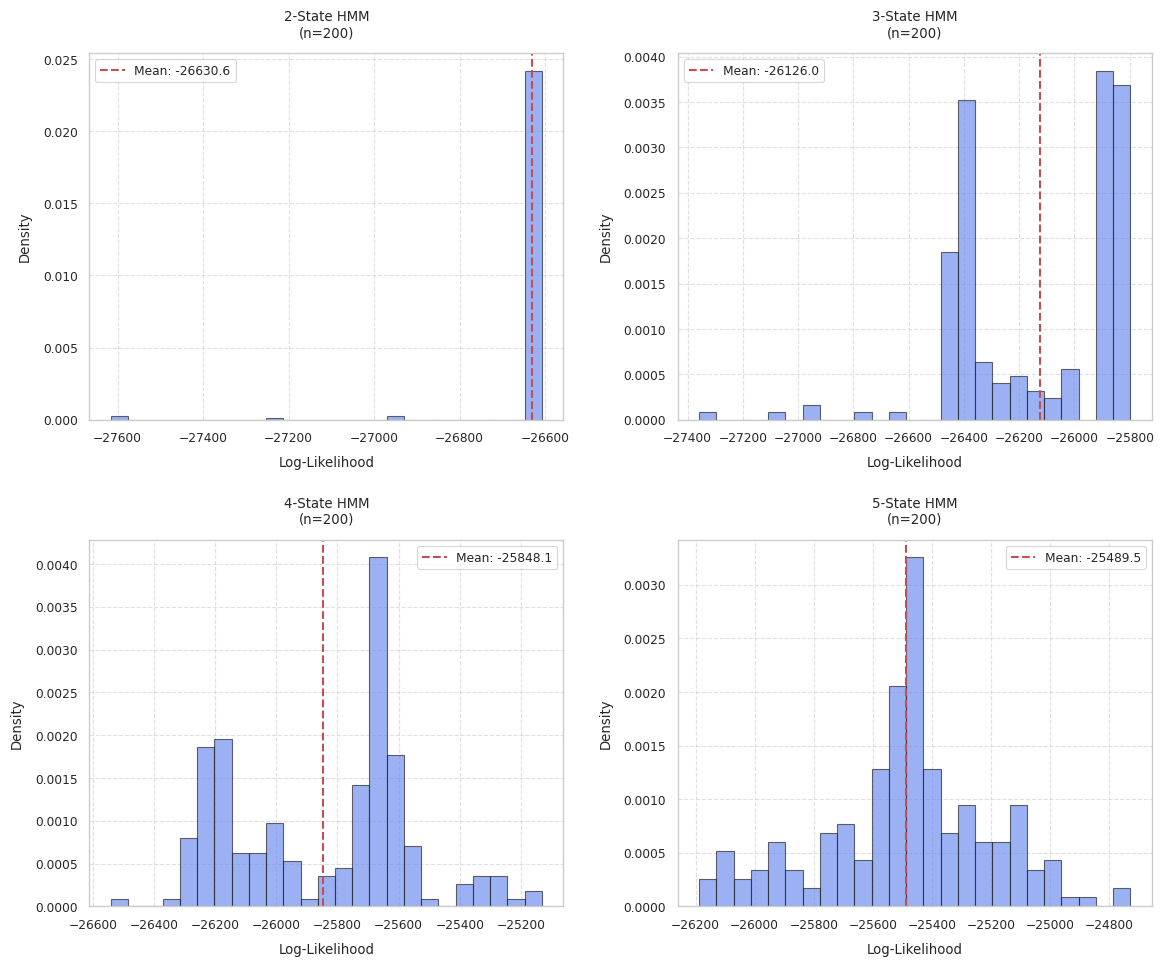

In [567]:
plot_ll_histograms(models)

Zaključujemo da je 4 optimalan broj stanja

In [568]:
h = best_models[4]

print(h.score(X, lengths))

hidden_states = h.predict(X, lengths=len(X))

-25131.338587731454


In [569]:
def plot_means_by_state(h, model_parameters_df):
    means = h.means_
    n_components = h.n_components
    feature_names = model_parameters_df.columns
    n_features = len(feature_names)

    data_list = []
    for i in range(n_components):
        for j in range(n_features):
            data_list.append(
                {
                    "Hidden State": f"State {i}",
                    "Feature": feature_names[j],
                    "Mean": means[i, j],
                }
            )
    means_df = pd.DataFrame(data_list)

    aspect_ratio = 1.5
    base_fontsize = 10
    fontsize = max(6, base_fontsize - n_features / (5 * aspect_ratio))

    g = sns.catplot(
        data=means_df,
        x="Feature",
        y="Mean",
        col="Hidden State",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Hidden {col_name}")

    for ax in g.axes.flat:
        if not ax.has_data():
            continue

        ax.set_xticks(np.arange(n_features))
        ax.set_xticklabels(feature_names, rotation=0, ha="center", fontsize=fontsize)

        ax.tick_params(axis="x", labelbottom=True)

        ax.grid(True, linestyle="--", alpha=0.7)

    g.set_axis_labels("Feature", "Mean Value")
    g.figure.suptitle("Mean Values per Hidden State", y=1.02, fontsize=16)

    g.figure.tight_layout(pad=2.0)

    plt.show()

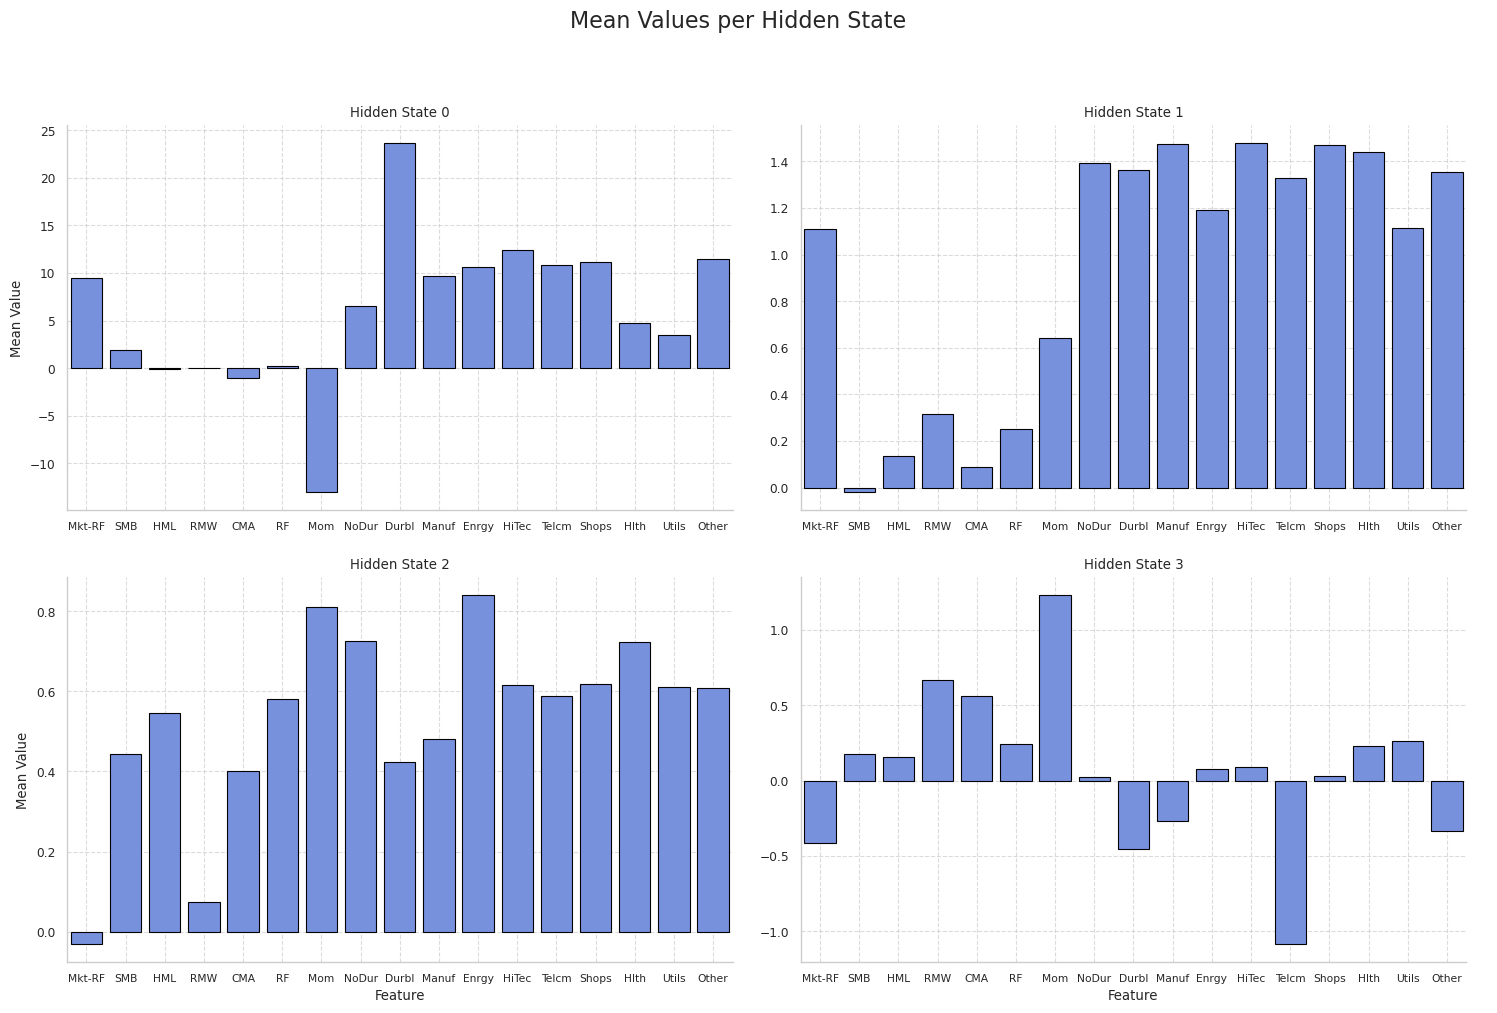

In [570]:
plot_means_by_state(h, model_parameters_df)

In [571]:
def plot_stdev_by_state(h, model_parameters_df):
    covars_raw = h.covars_
    feature_names = model_parameters_df.columns

    variances = np.diagonal(covars_raw, axis1=1, axis2=2)

    stdevs = np.sqrt(np.maximum(variances, 0))
    n_components, n_features = stdevs.shape

    stdev_df = pd.DataFrame(
        {
            "Hidden State": np.repeat(
                [f"State {i}" for i in range(n_components)], n_features
            ),
            "Feature": np.tile(feature_names, n_components),
            "Stdev": stdevs.ravel(),
        }
    )

    aspect_ratio = 1.5
    fontsize = max(6, 10 - n_features / (7.5))

    g = sns.catplot(
        data=stdev_df,
        x="Feature",
        y="Stdev",
        col="Hidden State",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Hidden {col_name}")

    for i, ax in enumerate(g.axes.flat):
        if i < n_components:
            ax.set_xticks(np.arange(n_features))
            ax.set_xticklabels(
                feature_names, rotation=0, ha="center", fontsize=fontsize
            )
            ax.tick_params(axis="x", labelbottom=True)
            ax.grid(True, linestyle="--", alpha=0.7)

    g.set_axis_labels("Feature", "Standard Deviation")
    g.figure.suptitle(
        "Feature Standard Deviations per Hidden State", y=1.02, fontsize=16
    )
    g.figure.tight_layout(pad=2.0)
    plt.show()

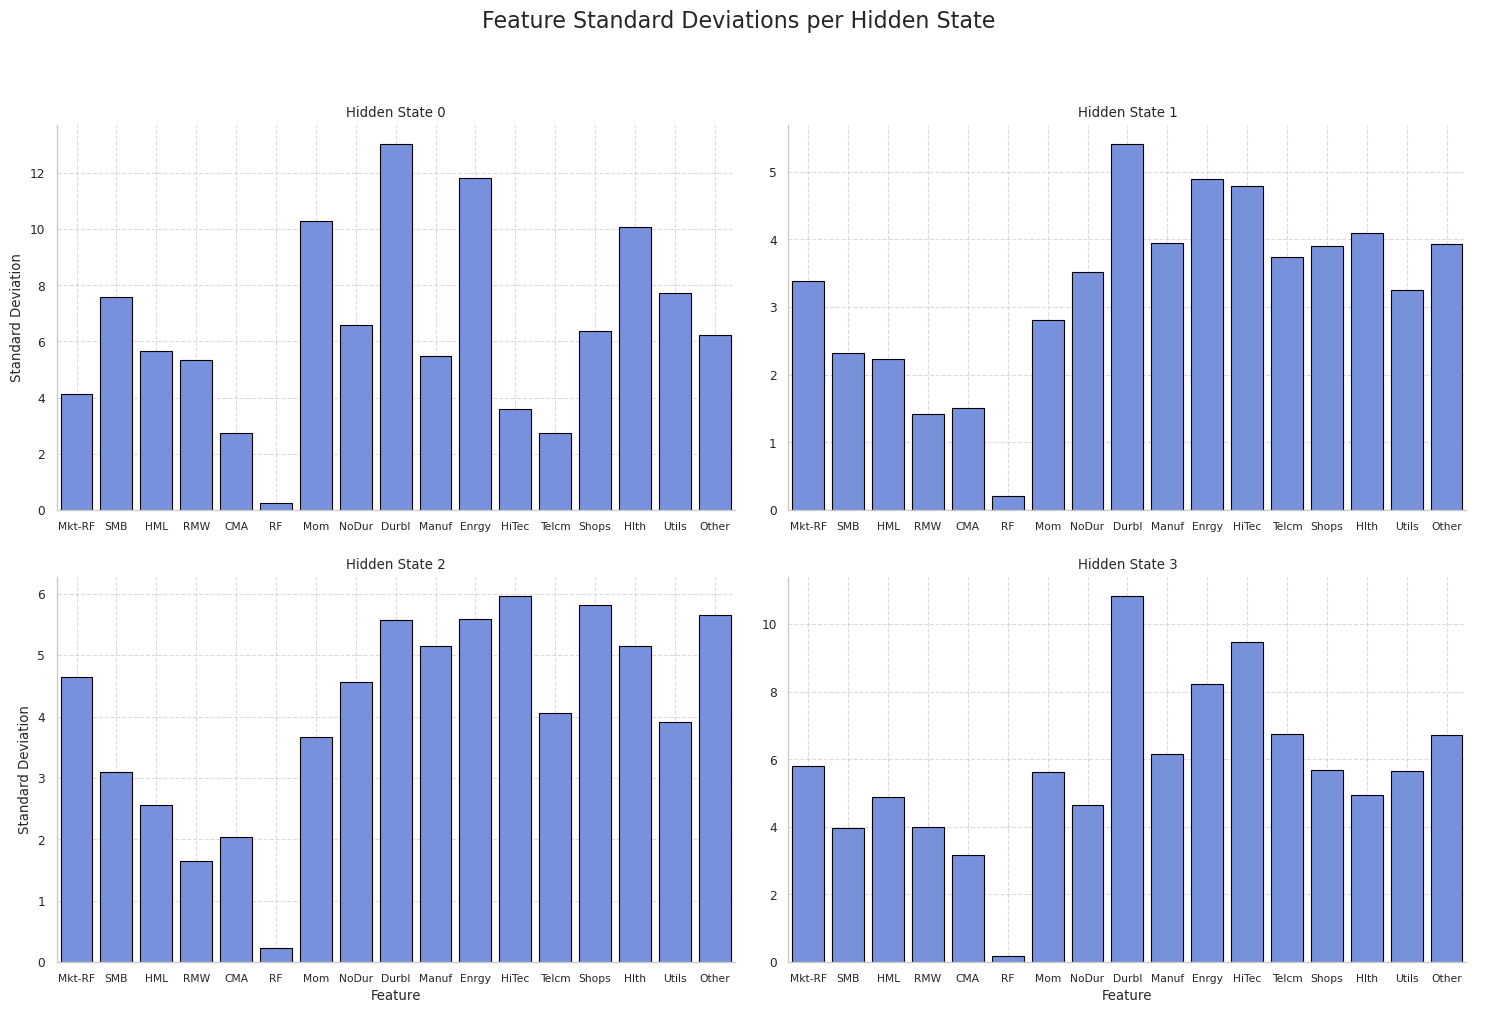

In [572]:
plot_stdev_by_state(h, model_parameters_df)

In [573]:
# currently not working, define better heuristic
def remap_hidden_states_by_covariance(h, hidden_states):
    cov_traces = [np.trace(c) for c in h.covars_]

    sorted_indices = np.argsort(cov_traces)

    h.means_ = h.means_[sorted_indices]
    h.covars_ = h.covars_[sorted_indices]
    h.transmat_ = h.transmat_[sorted_indices, :][:, sorted_indices]
    h.startprob_ = h.startprob_[sorted_indices]

    state_mapping = {old: new for new, old in enumerate(sorted_indices)}

    hidden_states = np.vectorize(state_mapping.get)(hidden_states)

    return hidden_states

In [574]:
def convert_to_correlation_matrix(covariance_matrix):

    d = np.sqrt(np.diag(covariance_matrix))
    correlation_matrix = covariance_matrix / np.outer(d, d)
    return correlation_matrix

In [575]:
def plot_correlation_heatmaps(correlation_matrices, factor_names):
    num_states = len(correlation_matrices)

    nrows = 2
    ncols = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), squeeze=False)
    axes_flat = axes.flatten()

    plot_limit = min(num_states, 4)
    mask = np.triu(np.ones_like(correlation_matrices[0], dtype=bool))

    for i in range(plot_limit):
        ax = axes_flat[i]
        sns.heatmap(
            correlation_matrices[i],
            mask=mask,
            cmap="coolwarm",
            linewidths=0.5,
            ax=ax,
            xticklabels=factor_names,
            yticklabels=factor_names,
            vmin=-1,
            vmax=1,
            cbar=(i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0),
            cbar_kws={"label": "Correlation"}
            if (i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0)
            else {},
            square=True,
        )
        ax.set_title(f"State {i} Correlations")
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
        plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

        if i % ncols != 0:
            ax.set_yticklabels([])

    for j in range(plot_limit, nrows * ncols):
        if j < len(axes_flat):
            fig.delaxes(axes_flat[j])

    fig.suptitle("Factor Correlation Matrices per Hidden State", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [576]:
covariance_matrices = h.covars_
correlation_matrices = []

for matrix in covariance_matrices:
    correlation_matrix = convert_to_correlation_matrix(matrix)
    correlation_matrices.append(correlation_matrix)


factor_names = model_parameters_df.columns.tolist()

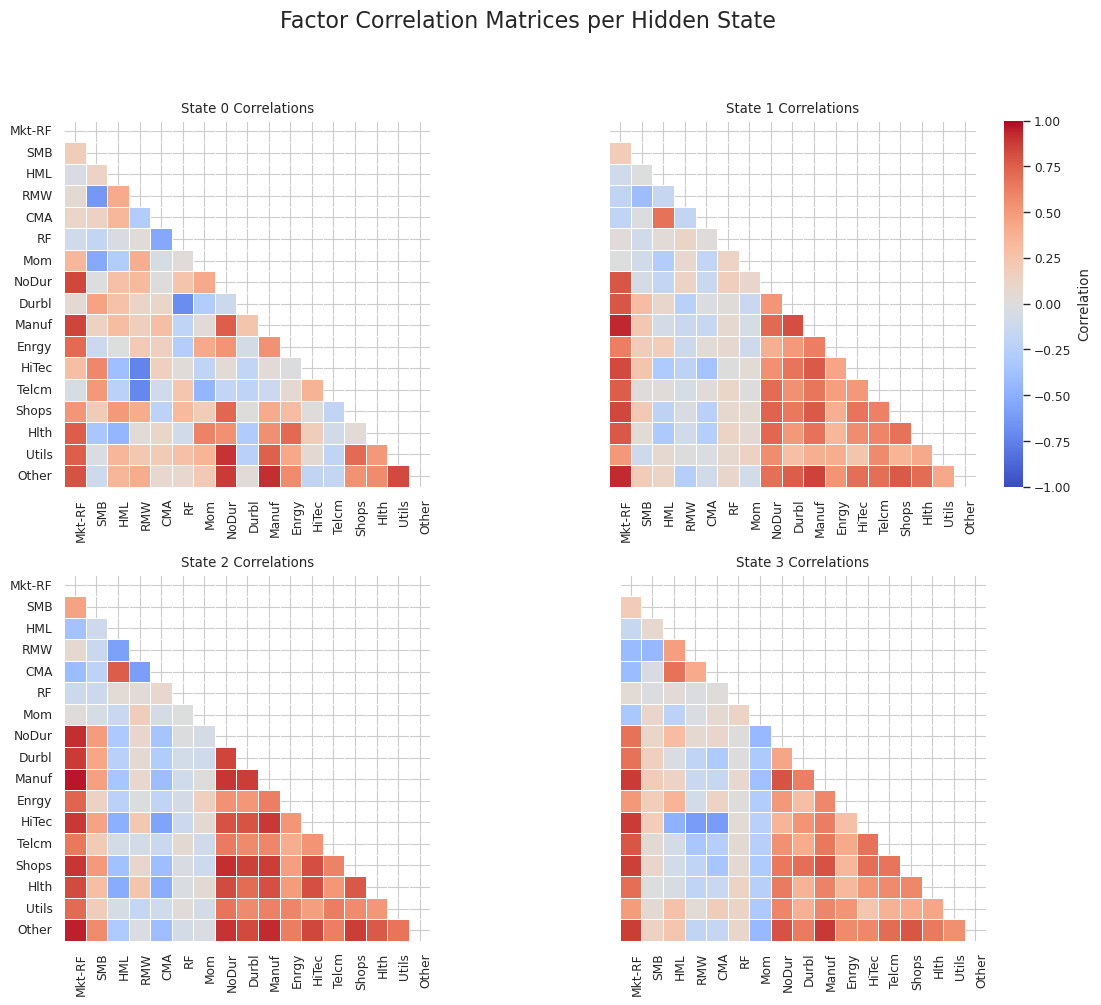

In [577]:
plot_correlation_heatmaps(correlation_matrices, factor_names)

In [578]:
def plot_transition_matrix(transmat, num_states):

    fig, ax = plt.subplots()
    sns.heatmap(
        transmat,
        annot=True,
        cmap="coolwarm",
        fmt=".3f",
        linewidths=0.5,
        ax=ax,
        xticklabels=[f"State {i}" for i in range(num_states)],
        yticklabels=[f"State {i}" for i in range(num_states)],
    )
    ax.set_title("Transition Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.show()

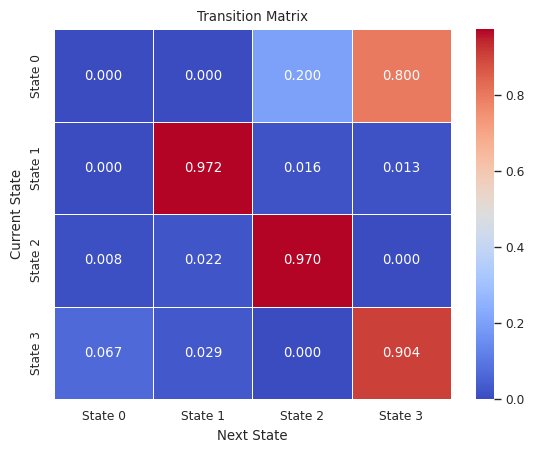

In [579]:
plot_transition_matrix(h.transmat_, h.n_components)

In [580]:
# calculate the average length of each state
state_lengths = defaultdict(list)

current_state = hidden_states[0]
counter = 1
for state in hidden_states[1:]:
    if state == current_state:
        counter += 1
    else:
        state_lengths[current_state].append(counter)
        counter = 1
        current_state = state

# sorted keys
sorted_keys = sorted(state_lengths.keys())
state_lengths = {key: state_lengths[key] for key in sorted_keys}
average_lengths = {state: np.mean(lengths) for state, lengths in state_lengths.items()}

In [581]:
model_2_states = best_models[2]

model_3_states = best_models[3]

In [582]:
state_probs_2 = model_2_states.predict_proba(X, lengths=len(X))
state_probs_3 = model_3_states.predict_proba(X, lengths=len(X))
state_probs_4 = h.predict_proba(X, lengths=len(X))

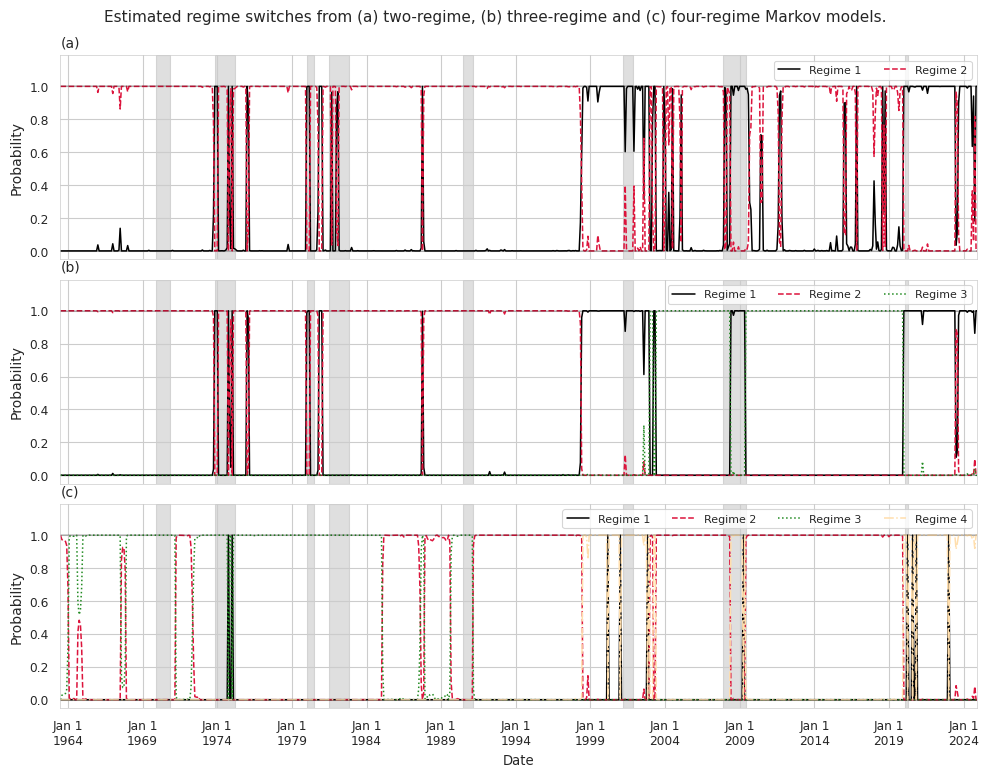

In [589]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.text(
    0.5,
    0.95,
    "Estimated regime switches from (a) two-regime, (b) three-regime and (c) four-regime Markov models.",
    ha="center",
    fontsize=11,
)

line_styles = ["-", "--", ":", "-."]
colors = ["black", "crimson", "forestgreen", "navajowhite"]

titles = ["(a)", "(b)", "(c)"]
probs = [state_probs_2, state_probs_3, state_probs_4]
n_regimes = [2, 3, 4]

for i, (ax, prob, n_regime) in enumerate(zip(axes, probs, n_regimes)):
    ax.set_title(titles[i], loc="left", fontsize=10)

    for j in range(n_regime):
        sns.lineplot(
            x=model_parameters_df.index,
            y=prob[:, j],
            ax=ax,
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f"Regime {j+1}",
        )

    ax.legend(loc="upper right", ncol=n_regime, frameon=True, fontsize="small")

    ax.set_ylim(-0.05, 1.19)
    ax.set_ylabel("Probability", fontsize=10)

    ax.set_xlim(model_parameters_df.index[0], model_parameters_df.index[-1])

    ax.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    ax.axhline(y=1, color="black", linestyle="-", alpha=0.2)

    for _, row in fred_recessions.iterrows():
        ax.axvspan(row["Peak"], row["Trough"], color="gray", alpha=0.25, zorder=0)

year_ticks = pd.date_range(
    start=model_parameters_df.index[0], end=model_parameters_df.index[-1], freq="5YS"
)
axes[2].set_xticks(year_ticks)
axes[2].set_xticklabels([f"Jan 1\n{date.year}" for date in year_ticks])

sns.despine()

for ax in axes:
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_linewidth(0.5)
    ax.spines["right"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.1)
plt.show()